# DSCI 100 Project Final Report - Group 15

## Using Player Behavioural Data to Predict Newsletter Subscriptions

Chloe Bayley, Ray Wu, William Tees-DeBeyer

## Introduction

For this data science project, a Computer Science research group at UBC, led by Frank Wood, has set up a Minecraft (a popular video game) server to collect data on player behaviour to study how people play video games. In particular, the researchers collected data on the players' ages, gender, experience level, subscription status to the game-related newsletter, and the total number of hours played on the server. This led us to question: **Can the age, playtime, gender and experience of a user be used to predict whether or not they will subscribe to a game-related newsletter?**

To explore this question, we will be using the players.csv dataeset, which contains the following variables: 
- experience: character variable that describes the experience level of a user.
- subscribe: logical variable that describes whether that user is subscribed to the newsletter (TRUE) or not (FALSE).
- hashedEmail: encrypted email of the user.
- played_hours: the total number of hours the user has on the MineCraft server.
- name: name of the user
- gender: categorical variable describing the gender of the user
- Age: numerical variable describinig the age of the user.

**Note**: For this project, hashedEmail and names are not relevant variables, and will be filtered out.


In [1]:
# Libraries used/ Run before everything else!
library(tidyverse)
library(repr)
library(tidymodels)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.6     ✔ rsample      1.2.1
✔ dials        1.3.0     ✔ tune         1.1.2
✔ infer        1.0.7     ✔ workflows    1.1.4
✔ modeldata    1.4.0     ✔ workflowsets 1.0.1
✔ parsnip      1.2.1     ✔ yardstick    1.3.1
✔ recipes      1.1.0     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filt

Methods and Results

We first tidied our data by removing unessecary columns to our anaylsis; hashed_email and name. 
The next step was to turn categorical variables to numerical. for the experience column, this was done following the natural order of the categories( beginner = 0, amateur =1 ,regular = 2,  veteran =3 pro =4). Gender was separated into male and non-male because the other gender categories had very little data and a followed a similar trend. The Age and hours played columns are already numerical so no change was necessary. The outcome variable is the subscribe column and FALSE is set to =0, and TRUE to =1. 

We then created a recipe with subscribe as the as the outcome, and played_hours, Age, Experience, and gender as the predictors. 
The scaling and normalizing step ensures all data is standaridized for the Euciliean distance calculation. 

We preformed a double split, 80% training data and 20% testing. 

Now we set up the KNN classification model, setting neighbors to tune so that k is changeable. 

the following step combines the recipe and model into a workflow 



In [8]:
#loads data 
players_data <- read.csv("players.csv")

Firstly, the code above reads the comma-separated dataset, players.csv, into R as an object named players_data.

In [10]:
#wrangling
players_data_wrangled <- players_data |>
    select(-hashedEmail, -name) |>
    mutate(gender = ifelse(gender == "Male", "Male", "Non-Male")) |>
    mutate(experience = case_when(
        experience == "Beginner" ~ 0,
        experience == "Amateur" ~ 1,
        experience == "Regular" ~ 2,
        experience == "Veteran" ~ 3,
        experience == "Pro" ~ 4,
    ))
players_data_wrangled

experience,subscribe,played_hours,gender,Age
<dbl>,<lgl>,<dbl>,<chr>,<int>
4,TRUE,30.3,Male,9
3,TRUE,3.8,Male,17
3,FALSE,0.0,Male,17
1,TRUE,0.7,Non-Male,21
2,TRUE,0.1,Male,21
1,TRUE,0.0,Non-Male,17
2,TRUE,0.0,Non-Male,19
1,FALSE,0.0,Male,21
1,TRUE,0.1,Male,47


This data is then wrangled. First, the hashedEmail and name variables are removed from the dataset using select(), as they do not have predictive value and are not relevant to the analysis. Following this, mutate() and ifelse() functions are used in conjunction to mutate the gender variables, such that all of the genders are categorized into either Male, or Non-Male. Finally, the case_when() function is used to mutate the character variables of experience into numerical values, allowing us to use it as a predictor for KNN classification.

### summary

We can see our data is tidy, every row an observation, every coloumn a variable, and every cell is filled (except for some NA's in Age). There are 196 players in total.

We have seven variables: "experience" "subscribe" "hashedEmail" "played_hours" "name" "gender" "Age"

-Experience is a class with a range of "Beginner, Amateur, Regular, Veteren, Pro"

-Subscribe is a boolean (True or False) that shows if they have subscribed to a game-related newsletter or not, this is our main predicitive focus.

-HashedEmail is a character string that shows an encoded identifier, no useful for us but essential if contact with the person is needed.

-Played hours is a dbl, a decimal number with one decimal of precision, and is how many hours were played on the study's server.

-Name is a character string and is the first name of the person.

-Gender is also a character string and is the gender of the person, we will treat it as a class, Male and Other.

-Age is a dbl but has no decimal places in the data and is treated as an integer, it is the age of the person.



#summary

We can see our data is tidy, every row an observation, every coloumn a variable, and every cell is filled (except for one NA in Age). There are 196 players in total.

We have seven variables: "experience" | "subscribe" | "hashedEmail" | "played_hours" | "name" | "gender" | "Age"

-Experience is a class with a range of "Beginner, Amateur, Regular, Veteren, Pro"

-Subscribe is a boolean (True or False) that shows if they have subscribed to a game-related newsletter or not, this is our main predicitive focus.

-HashedEmail is a character string that shows an encoded identifier, no useful for us but essential if contact with the person is needed.

-Played hours is a dbl, a decimal number with one decimal of precision, and is how many hours were played on the study's server.

-Name is a character string and is the first name of the person.

-Gender is also a character string and is the gender of the person, we will treat it as a class, Male and Other.

-Age is a dbl but has no decimal places in the data and is treated as an integer, it is the age of the person.

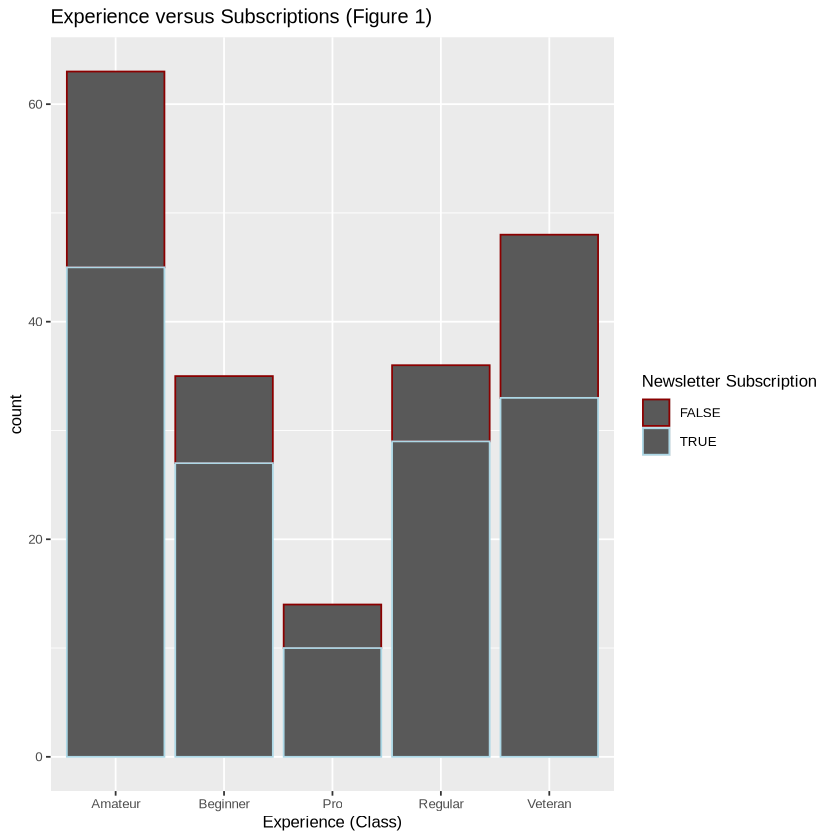

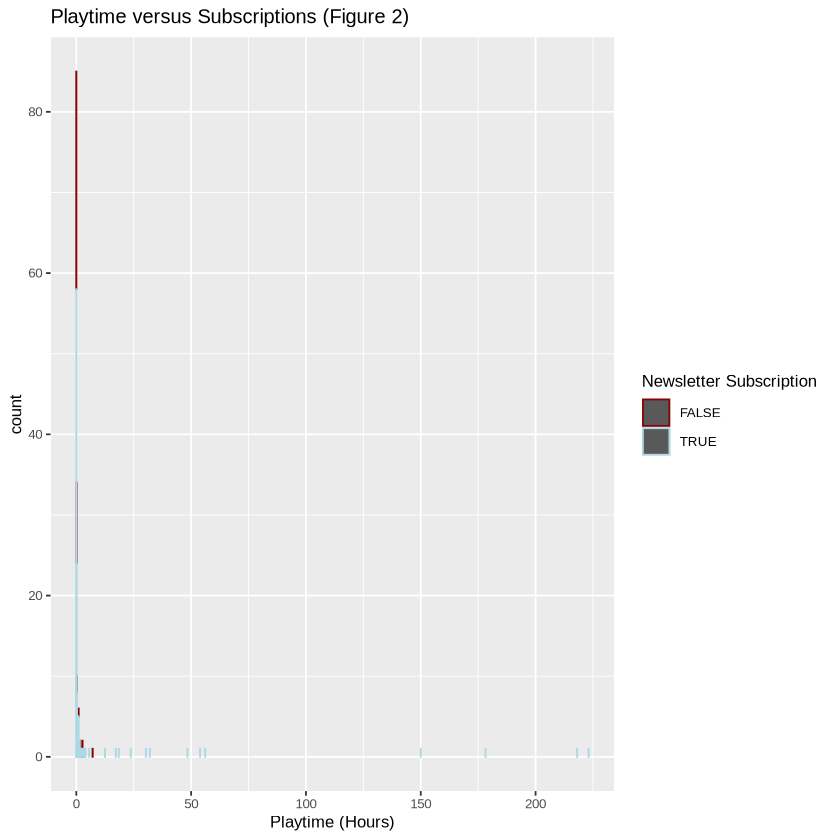

In [12]:
#exploratory visualization/graphs

#Plotting experience versus subscriptions
experience_plot <- players_data|>
  ggplot(aes(x = experience, color = subscribe)) +
  geom_bar() +
  labs(x = "Experience (Class)",
       color = "Newsletter Subscription") +
  scale_color_manual(values = c("darkRed", "green")) +
ggtitle("Experience versus Subscriptions (Figure 1)") +
  theme(text = element_text(size = 10))

experience_plot


#Plotting playtime versus subscriptions
playtime_plot <- players_data|>
  ggplot(aes(x = played_hours, color = subscribe)) +
  geom_bar() +
  labs(x = "Playtime (Hours)",
       color = "Newsletter Subscription") +
  scale_color_manual(values = c("darkRed", "green")) +
ggtitle("Playtime versus Subscriptions (Figure 2)") +
  theme(text = element_text(size = 10))

playtime_plot

In [ ]:
#analysis

In [ ]:
#visualization of analysis